In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
import os

from datetime import datetime
from sklearn.ensemble import RandomForestRegressor

In [3]:
#Reading the dataset in Pandas
train=pd.read_csv("data/walmart-recruiting-store-sales-forecasting/train.csv")
test=pd.read_csv("data/walmart-recruiting-store-sales-forecasting/test.csv")
stores=pd.read_csv("data/walmart-recruiting-store-sales-forecasting/stores.csv")
features = pd.read_csv("data/walmart-recruiting-store-sales-forecasting/features.csv")

# Exploratory Data Analysis:

## stores.csv

In [7]:
print("Types of stores:")
stores['Type'].value_counts()

Types of stores:


A    22
B    17
C     6
Name: Type, dtype: int64

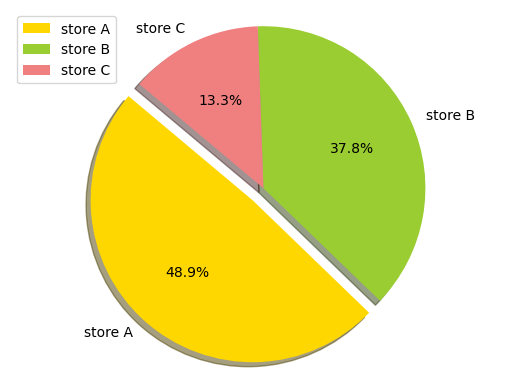

In [4]:
#pie-chart for the visual representation of store types
#https://pythonspot.com/matplotlib-pie-chart/
# Data to plot
labels = 'store A','store B','store C'
sizes = [(22/(45))*100,(17/(45))*100,(6/(45))*100]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels, loc="best")
plt.axis('equal')
plt.show()

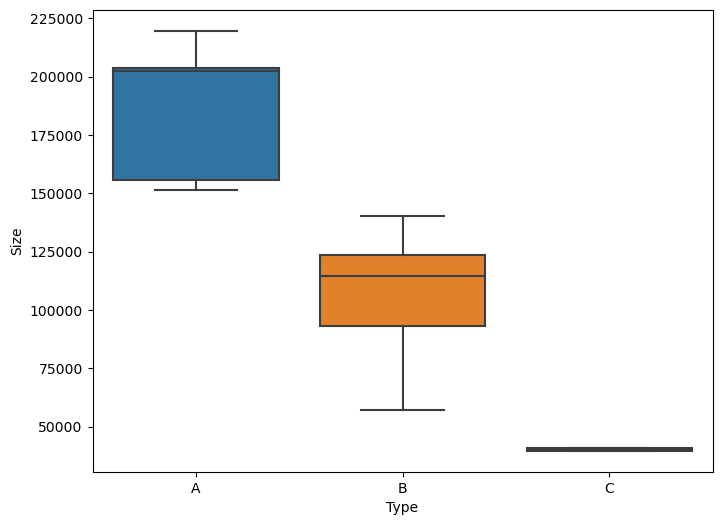

In [6]:
# boxplot for sizes of types of stores
store_type = pd.concat([stores['Type'], stores['Size']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Type', y='Size', data=store_type, showfliers=False)

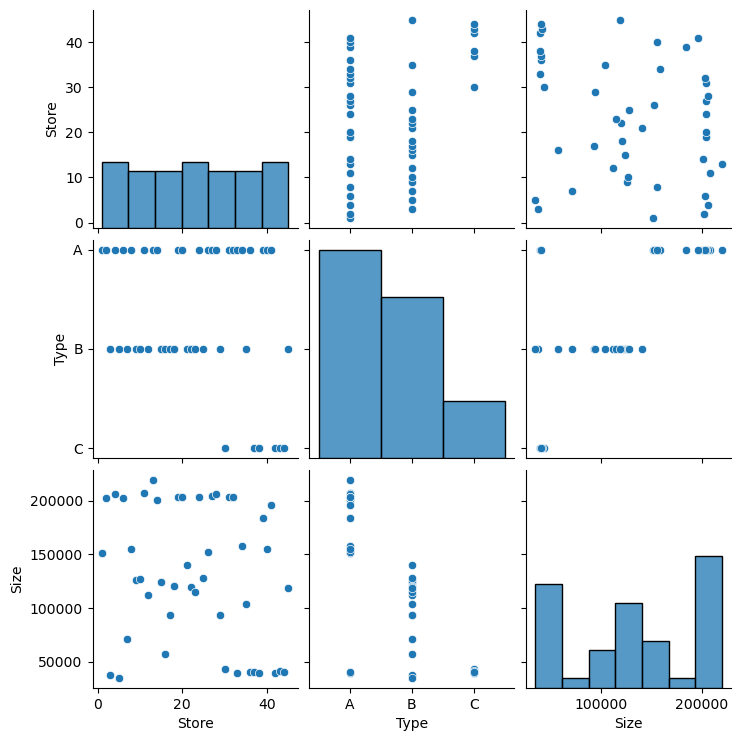

In [8]:
sns.pairplot(stores, vars=['Store','Type','Size'])

## Train.csv

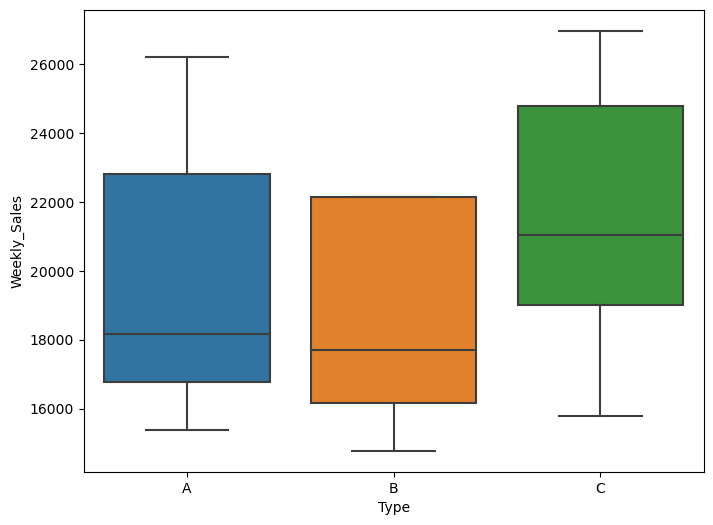

In [9]:
#boxplot for weekly sales for different types of stores :
store_sale = pd.concat([stores['Type'], train['Weekly_Sales']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Type', y='Weekly_Sales', data=store_sale, showfliers=False)

In [10]:
train['IsHoliday'].value_counts()

False    391909
True      29661
Name: IsHoliday, dtype: int64

In [11]:
objects = ('Non holidays','Holidays')
y_pos = np.arange(len(objects))

In [12]:
# total count of sales on holidays and non holidays
print('sales on non-holiday : ',train[train['IsHoliday']==False]['Weekly_Sales'].count().round(1))
print('sales on holiday : ',train[train['IsHoliday']==True]['Weekly_Sales'].count().round(1))

sales on non-holiday :  391909
sales on holiday :  29661


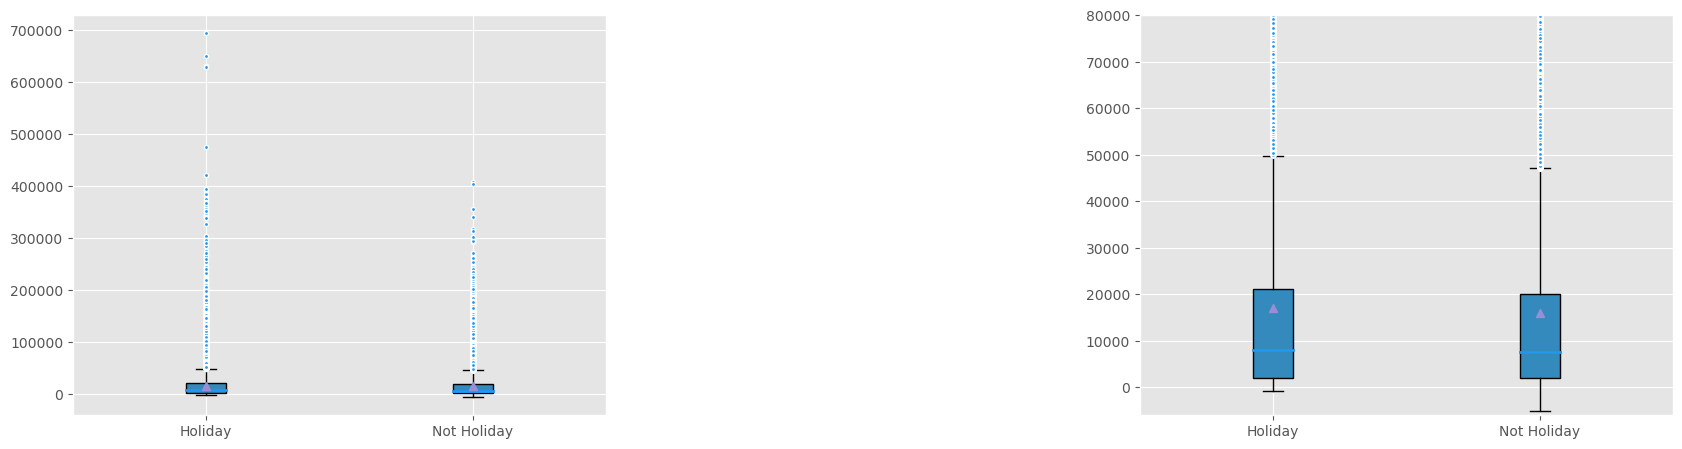

In [13]:
#https://www.kaggle.com/yepp2411/walmart-prediction-1-eda-with-time-and-space
plt.style.use('ggplot')
fig, axes = plt.subplots(1,2, figsize = (20,5))
fig.subplots_adjust(wspace=1, hspace=1)
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

sales_holiday=train[['IsHoliday','Weekly_Sales']]
target=[sales_holiday['Weekly_Sales'].loc[sales_holiday['IsHoliday']==True],sales_holiday['Weekly_Sales'].loc[sales_holiday['IsHoliday']==False]]
labels=['Holiday','Not Holiday']

#median
medianprop={'color':'#2196F3',
            'linewidth': 2,
            'linestyle':'-'}
# outliers

flierprop={'color' : '#EC407A',
          'marker' : 'o',
          'markerfacecolor': '#2196F3',
          'markeredgecolor':'white',
          'markersize' : 3,
          'linestyle' : 'None',
          'linewidth' : 0.1}



axes[0].boxplot(target,labels=labels, patch_artist = 'Patch',
                  showmeans=True,
                  flierprops=flierprop,
                  medianprops=medianprop)


axes[1].boxplot(target,labels=labels, patch_artist = 'Patch',
                  showmeans=True,
                  flierprops=flierprop,
                  medianprops=medianprop)

axes[1].set_ylim(-6000,80000)

plt.show()

# Advance Feature

In [15]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

#week feature
train['Week'] = train['Date'].dt.week
test['Week'] = test['Date'].dt.week


In [16]:
train['Day_of_week'] =train['Date'].dt.dayofweek
test['Day_of_week'] =test['Date'].dt.dayofweek

train['Month'] =train['Date'].dt.month 
test['Month'] =test['Date'].dt.month 

train['Year'] =train['Date'].dt.year
test['Year'] =test['Date'].dt.year

train['Day'] =train['Date'].dt.day 
test['Day'] =test['Date'].dt.day


Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Week',
       'Day_of_week', 'Month', 'Year', 'Day'],
      dtype='object')

### Merge all the features


In [21]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [22]:
features['Date'] = pd.to_datetime(features['Date'])

#merge all the features
train_with_feature = pd.merge_asof(train, features, on='Store',by='Date')
test_with_feature = pd.merge_asof(test, features, on='Store',by='Date')

In [23]:
#train data
#let's take mean of Temp and Unemployment
train_with_feature['Temp_mean'] = train_with_feature['Temperature'].mean()
train_with_feature['Unemployment_mean'] = train_with_feature['Unemployment'].mean()

#test data
test_with_feature['Temp_mean'] = test_with_feature['Temperature'].mean()
test_with_feature['Unemployment_mean'] = test_with_feature['Unemployment'].mean()

In [24]:
#merge all the features
train_with_feature_new = pd.merge(train_with_feature,stores)
test_with_feature_new = pd.merge(test_with_feature,stores)

In [25]:
#drop the dublicate of IsHoliday column
train_with_feature = train_with_feature_new.drop(columns=['IsHoliday_x'])
test_with_feature = test_with_feature_new.drop(columns=['IsHoliday_x'])

#let's rename the IsHoliday_y column to IsHoliday
train_with_feature = train_with_feature.rename(columns={"IsHoliday_y": "IsHoliday"})
test_with_feature = test_with_feature.rename(columns={"IsHoliday_y": "IsHoliday"})

## changing IsHoliday column with Flase to be 0 and True to be 1



In [26]:
def paron(x):
    if x == False:
        return 0
    return 1
#Train.csv
actualScore = train_with_feature['IsHoliday']
posiveNegave = actualScore.map(paron)
train_with_feature['IsHoliday'] = posiveNegave
print("Shape of train_with_feature: ", train_with_feature.shape)
train_with_feature.head(3)

Shape of train_with_feature:  (421570, 23)


,Store,Dept,Date,Weekly_Sales,Week,Day_of_week,Month,Year,Day,Temperature,...,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Temp_mean,Unemployment_mean,Type,Size
0,1,1,2010-02-05,24924.50,5,4,2,2010,5,42.31,...,NaN,NaN,NaN,211.096358,8.106,0,60.090059,7.960289,A,151315
1,1,1,2010-02-12,46039.49,6,4,2,2010,12,38.51,...,NaN,NaN,NaN,211.242170,8.106,1,60.090059,7.960289,A,151315
2,1,1,2010-02-19,41595.55,7,4,2,2010,19,39.93,...,NaN,NaN,NaN,211.289143,8.106,0,60.090059,7.960289,A,151315


In [27]:
#Test.csv

actualScore_test = test_with_feature['IsHoliday']
posiveNegave = actualScore.map(paron)
test_with_feature['IsHoliday'] = posiveNegave
print("Shape of test_with_feature: ", test_with_feature.shape)
test_with_feature.head(3)

Shape of test_with_feature:  (115064, 22)


,Store,Dept,Date,Week,Day_of_week,Month,Year,Day,Temperature,Fuel_Price,...,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Temp_mean,Unemployment_mean,Type,Size
0,1,1,2012-11-02,44,4,11,2012,2,55.32,3.386,...,50.82,3639.90,2737.42,223.462779,6.573,0,53.941804,6.868733,A,151315
1,1,1,2012-11-09,45,4,11,2012,9,61.24,3.314,...,40.28,4646.79,6154.16,223.481307,6.573,1,53.941804,6.868733,A,151315
2,1,1,2012-11-16,46,4,11,2012,16,52.92,3.252,...,103.78,1133.15,6612.69,223.512911,6.573,0,53.941804,6.868733,A,151315


## convert ‘Types’ of the store to numeric values.

In [28]:
def type_count(x):
    ''' This function will chang
    IsHoliday column with Flase to be 0 
    and True to be 1'''
    
    if x == 'A':
        return 1
    elif x == 'B':
        return 2
    return 3

#Train.csv
actualScore = train_with_feature['Type']
type_coun = actualScore.map(type_count)
train_with_feature['Types'] = type_coun

In [29]:
#Test.csv
actualScore = test_with_feature['Type']
type_coun = actualScore.map(type_count)
test_with_feature['Types'] = type_coun

In [30]:
train_with_feature.describe()

,Store,Dept,Weekly_Sales,Week,Day_of_week,Month,Year,Day,Temperature,Fuel_Price,...,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Temp_mean,Unemployment_mean,Size,Types
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.0,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,...,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000,4.215700e+05,4.215700e+05,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,25.826762,4.0,6.449510,2010.968591,15.673131,60.090059,3.361027,...,1439.421384,3383.168256,4628.975079,171.201947,7.960289,0.070358,6.009006e+01,7.960289e+00,136727.915739,1.589912
std,12.785297,30.492054,22711.183519,14.151887,0.0,3.243217,0.796876,8.753549,18.447931,0.458515,...,9623.078290,6292.384031,5962.887455,39.159276,1.863296,0.255750,3.569060e-11,3.952754e-11,60980.583328,0.666337
min,1.000000,1.000000,-4988.940000,1.000000,4.0,1.000000,2010.000000,1.000000,-2.060000,2.472000,...,-29.100000,0.220000,135.160000,126.064000,3.879000,0.000000,6.009006e+01,7.960289e+00,34875.000000,1.000000
25%,11.000000,18.000000,2079.650000,14.000000,4.0,4.000000,2010.000000,8.000000,46.680000,2.933000,...,5.080000,504.220000,1878.440000,132.022667,6.891000,0.000000,6.009006e+01,7.960289e+00,93638.000000,1.000000
50%,22.000000,37.000000,7612.030000,26.000000,4.0,6.000000,2011.000000,16.000000,62.090000,3.452000,...,24.600000,1481.310000,3359.450000,182.318780,7.866000,0.000000,6.009006e+01,7.960289e+00,140167.000000,1.000000
75%,33.000000,74.000000,20205.852500,38.000000,4.0,9.000000,2012.000000,23.000000,74.280000,3.738000,...,103.990000,3595.040000,5563.800000,212.416993,8.572000,0.000000,6.009006e+01,7.960289e+00,202505.000000,2.000000
max,45.000000,99.000000,693099.360000,52.000000,4.0,12.000000,2012.000000,31.000000,100.140000,4.468000,...,141630.610000,67474.850000,108519.280000,227.232807,14.313000,1.000000,6.009006e+01,7.960289e+00,219622.000000,3.000000


In [31]:
train_with_feature=train_with_feature.drop(['Type'], axis=1)
test_with_feature=test_with_feature.drop(['Type'], axis=1)

# Train and Test dataset Correlations

[]

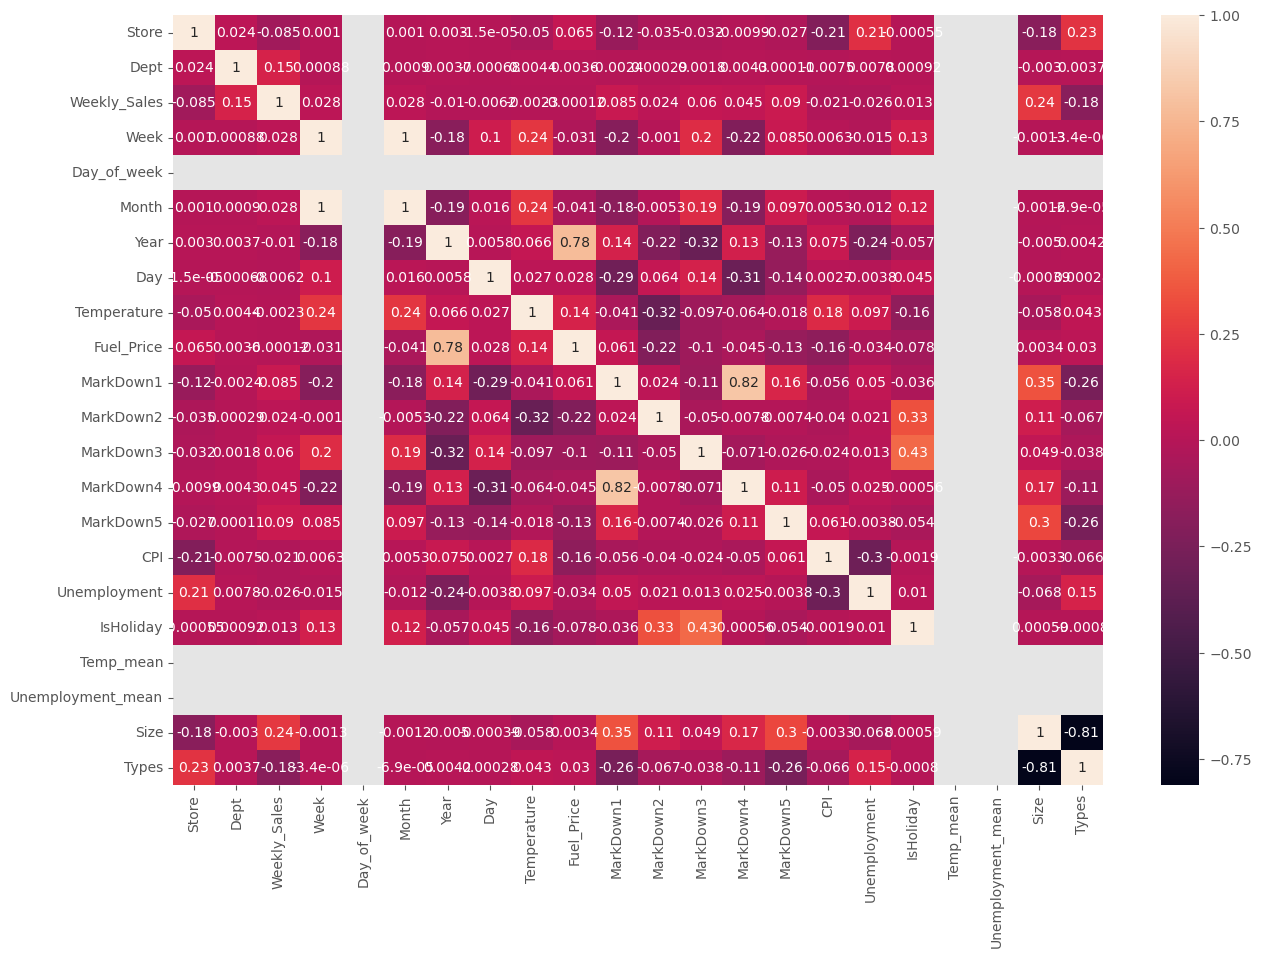

In [32]:
corr = train_with_feature.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True)
plt.plot()

[]

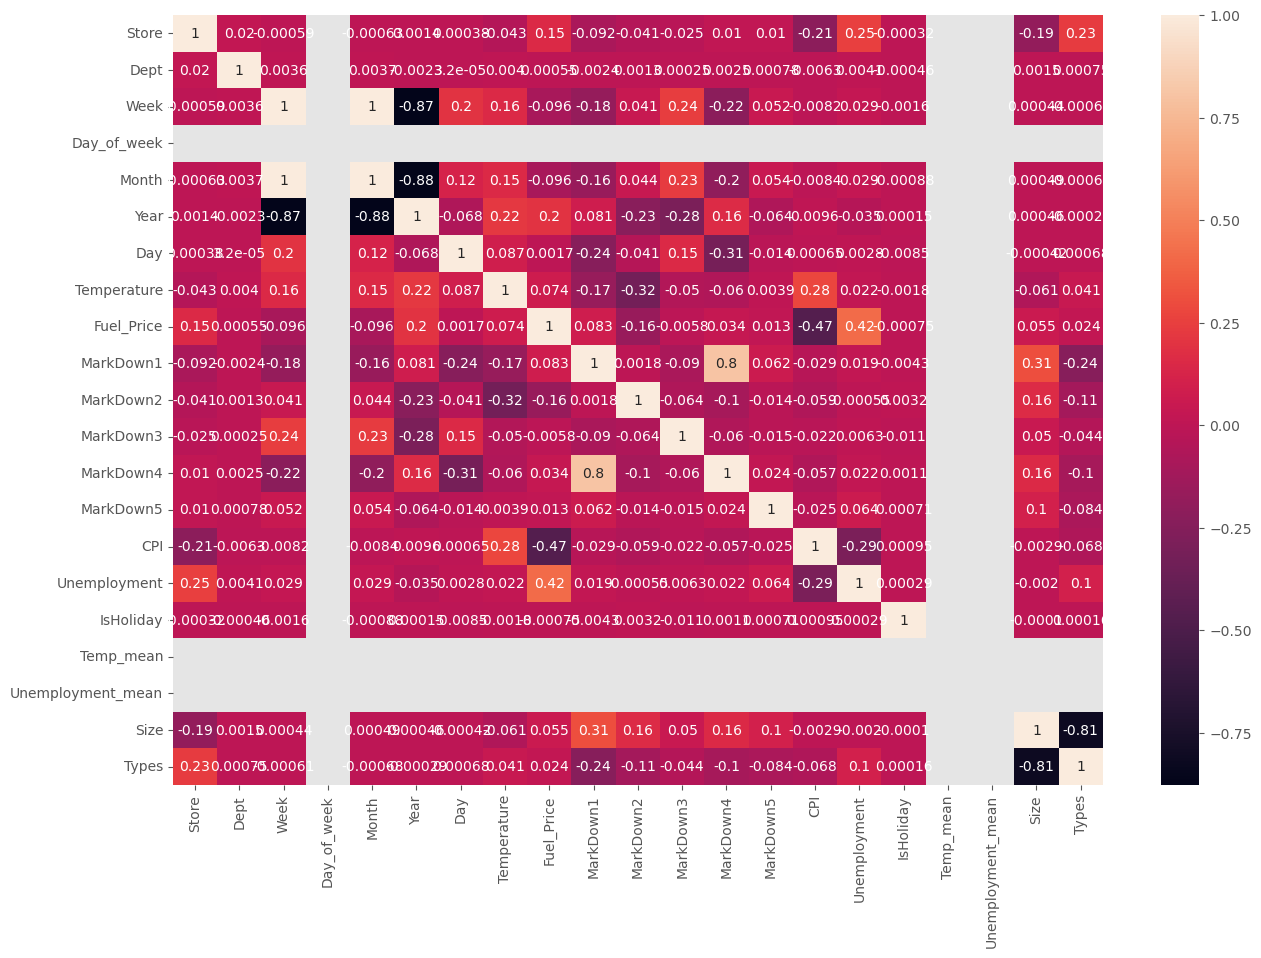

In [33]:
corr = test_with_feature.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True)
plt.plot()

# Finding Missing Values

In [34]:
print(train_with_feature.isnull().sum())
print("*"*30)
print(test_with_feature.isnull().sum())

Store                     0
Dept                      0
Date                      0
Weekly_Sales              0
Week                      0
Day_of_week               0
Month                     0
Year                      0
Day                       0
Temperature               0
Fuel_Price                0
MarkDown1            270889
MarkDown2            310322
MarkDown3            284479
MarkDown4            286603
MarkDown5            270138
CPI                       0
Unemployment              0
IsHoliday                 0
Temp_mean                 0
Unemployment_mean         0
Size                      0
Types                     0
dtype: int64
******************************
Store                    0
Dept                     0
Date                     0
Week                     0
Day_of_week              0
Month                    0
Year                     0
Day                      0
Temperature              0
Fuel_Price               0
MarkDown1              149
MarkDown2      

In [35]:
train_with_feature=train_with_feature.fillna(0)
test_with_feature=test_with_feature.fillna(0)

In [36]:
# so, let's add mean of Fuel and mean of CPI feature
#train data
train_with_feature['Fuel_Price_mean'] = train_with_feature['Fuel_Price'].mean()
train_with_feature['CPI_mean'] = train_with_feature['CPI'].mean()
#test data
test_with_feature['CPI_mean'] = test_with_feature['CPI'].mean()
test_with_feature['Fuel_Price_mean'] = test_with_feature['Fuel_Price'].mean()

## Feature Selection:

In [37]:
features_drop=['CPI','Unemployment','Fuel_Price','Day_of_week','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
train_final=train_with_feature.drop(features_drop, axis=1)
test_final=test_with_feature.drop(features_drop, axis=1)

In [38]:

#train
train_X=train_final.drop(['Weekly_Sales','Date'], axis=1)
train_y=train_final['Weekly_Sales'] 

#test
test_X=test_final.drop('Date',axis=1).copy()
train_X.shape, train_y.shape, test_X.shape

((421570, 14), (421570,), (115064, 14))

# Machine Learning Models

In [39]:
clf = RandomForestRegressor(n_estimators=100)
clf.fit(train_X, train_y)
y_pred_rf=clf.predict(test_X)
acc_rf= round(clf.score(train_X, train_y) * 100,3)

Accuracy: {acc_rf} %


In [41]:
print (f"Accuracy: {acc_rf} %")

Accuracy: 99.739 %
